# Project 5: Multimodal Models

In this project, you will explore multimodal tasks that interface language with vision, such as image retrieval, caption retrieval, and image captioning. We will work with [Concadia](https://arxiv.org/abs/2104.08376), an image-text dataset scraped from Wikipedia focused on the relationship between images and the textual context. First, you will use CLIP for image retrieval and caption retrieval. Then, we will explore how implementing a Rational Speech Acts inference procedure can improve retrieval performance. Finally, we will generate our own captions for these images.

## Setup

First, we will install the required dependencies and download the dataset.

In Kaggle, you may want to turn on file persistence (Right Sidebar > Session Options > Persistence > Files only) so you don't have to re-download the dataset every time you restart this notebook.

In [1]:
%%capture
!pip install transformers
!pip install gdown

In [2]:
%%capture
# Download dataset
# resized.zip
!gdown --id 1gDhVlOwcGcwBT5LWYwgn9xEElGlKVpFb
!unzip /kaggle/working/resized.zip
# wiki_split.json
!gdown --id 1kiTSiqk7y7JdHssXjoLwcOomC7lhb5k8

In [3]:
import json
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer, AutoProcessor, AutoModelForCausalLM
import torch

Before proceeding, let's verify that we're connected to a GPU runtime and that torch can detect the GPU. We'll define a variable device here to use throughout the code so that we can easily change to run on CPU for debugging.

In [4]:
assert torch.cuda.is_available()
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


## Dataset Setup

For this project, let's load up the validation split of the dataset and inspect a sample.

Concadia consists of images paired with _captions_, which provide additional context, and _descriptions_, which are intended to replace the image (e.g. for alt-text). We'll be comparing captions and descriptions for various multimodal tasks, so feel free to explore what those instances look like. You may also want to refer to the paper for context.

In [5]:
with open("/kaggle/working/wiki_split.json") as f:
    data = json.load(f)["images"]
val = [d for d in data if d["split"] == "val"]
print("Number of validation examples:", len(val))

Number of validation examples: 9693


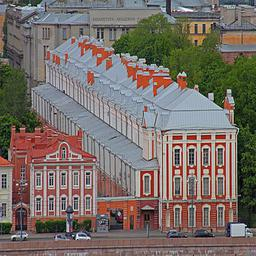

Caption: Rand completed a three-year program at Petrograd State University.
Description: The Twelve Collegia of what was then Petrograd State University


In [6]:
# Inspect a data sample
img = Image.open(f"/kaggle/working/resized/{val[0]['filename']}")
display(img)
print("Caption:", val[0]["caption"]["raw"])
print("Description:", val[0]["description"]["raw"])

## Part 1: Image & Text Retrieval


First, we'll retrieve images from the dataset from captions and descriptions, and evaluate the relative performance of retrieving with captions vs. descriptions for a subset of the validation set.

In [7]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Evaluate on a subset of the validation set
MAX_LEN = 70
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
data = [d for d in val if len(tokenizer(d["description"]["raw"])["input_ids"]) < MAX_LEN
        and len(tokenizer(d["caption"]["raw"])["input_ids"]) < MAX_LEN]
data = data[:1000]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (152 > 77). Running this sequence through the model will result in indexing errors


In [8]:
def rank_images(queries, images):
    """Ranks images for a batch of text queries by their CLIP similarity score.
    Args:
        queries: a list with batch of N text queries
        images: a list with a batch of N images
    Returns:
         A NxN array with image indices sorted by retrieval score for each query.
    """
    # YOUR CODE HERE
    ##
    inputs= processor(text=queries, images=images,return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs=model(**inputs)
        scores = outputs.logits_per_text
        ranked_images_indices = [sorted(list(range(len(images))), key=lambda x: scores[i][x], reverse=True) for i in range(len(images))]
    return ranked_images_indices


You will implement several retrieval metrics:
* Mean reciprocal rank: the average 1/rank of the true image for a query
* Top-1 accuracy: the % of instances where the true image is the top result for a query
* Top-k accuracy (k=10): the % of instances where the true image is in the top k results for a query

In [9]:
def mrr(batch_outputs):
    # YOUR CODE HERE
    ###
    tot_rank=[]
    true_indices=list(range(len(batch_outputs)))
    for true_index,output in enumerate(batch_outputs):
        rank_rec=1/(output.index(true_index)+1)
        tot_rank.append(rank_rec)
    return sum(tot_rank)/len(tot_rank)
    
def top1_accuracy(batch_outputs):
    # YOUR CODE HERE
    ### 
    true_percent=0
    for true_index,output in enumerate(batch_outputs):
        if true_index==output[0]:
            true_percent+=1
    return true_percent/len(batch_outputs)
    
def topk_accuracy(batch_outputs, k=10):
    # YOUR CODE HERE
    ###
    true_percent=0
    for true_index,output in enumerate(batch_outputs):
        if true_index==output[0]:
            true_percent+=1
    return true_percent/len(batch_outputs)

Now we'll compute each of these metrics for retrieving images based on captions vs. descriptions.

You should be getting >.60 MRR, >50% top-1 accuracy and >80% top-10 accuracy for both.

In [10]:
captions = [ex["caption"]["raw"] for ex in data]
descs = [ex["description"]["raw"] for ex in data]
images = [Image.open(f"/kaggle/working/resized/{ex['filename']}") for ex in data]

In [11]:
batch_outputs_cap = rank_images(captions, images)
print("Caption-based retrieval:")
print("MRR: ", mrr(batch_outputs_cap))
print("Top-1 acc: ", top1_accuracy(batch_outputs_cap))
print("Top-10 acc: ", topk_accuracy(batch_outputs_cap))
np.save("image_retrieval_caption.npy", batch_outputs_cap)

batch_outputs_desc = rank_images(descs, images)
print("Descriptions-based retrieval:")
print("MRR: ", mrr(batch_outputs_desc))
print("Top-1 acc: ", top1_accuracy(batch_outputs_desc))
print("Top-10 acc: ", topk_accuracy(batch_outputs_desc))
np.save("image_retrieval_desc.npy", batch_outputs_desc)

Caption-based retrieval:
MRR:  0.6964466665955885
Top-1 acc:  0.579
Top-10 acc:  0.579
Descriptions-based retrieval:
MRR:  0.6926209856822991
Top-1 acc:  0.589
Top-10 acc:  0.589


Now we'll look at the inverse problem: for a given image, does the corresponding caption or description in the dataset score higher?

In [12]:
def caption_better(captions, descriptions, images):
    """For a batch of paired (caption, description, image), returns True for each batch element
    if the caption scores higher for the image than the description.
    Args:
        captions: a list with batch of N text captions
        descriptions:  list with batch of N text descriptions
        images: a list with a batch of N images
    Returns:
         A list of N booleans, True if the caption scores higher for the image
    """
    # YOUR CODE HERE
    ##
    is_better=[]
    dif_score=[]
    caption_input=processor(text=captions, images=images,return_tensors="pt", padding=True, truncation=True).to("cuda")
    description_input=processor(text=descriptions, images=images,return_tensors="pt", padding=True, truncation=True).to("cuda")
    with torch.no_grad():
        cap_output=model(**caption_input)
        des_output=model(**description_input)
        cap_score = cap_output.logits_per_image
        des_score =  des_output.logits_per_image
    for i in range(len(images)):
        cap=cap_score[i][i]
        des=des_score[i][i]
        dif=cap-des
        if cap>des:
            is_better.append(True)
            dif_score.append((i,dif))
        else:
            is_better.append(False)
    return is_better
    
#better_rate,dif_score=caption_better(captions, descs, images)    
print("% of examples where caption scores more highly:", np.mean(caption_better(captions, descs, images)))

% of examples where caption scores more highly: 0.525


You should see >50% of examples where the caption scores more highly.

### Qualitative Analysis Part 1: Image & Text Retrieval

In the report, provide the following analysis:
* Investigate a couple of examples where image retrieval fails, and systematic model issues you observe (if any).
* Are there any differences between the failure modes of retrieving based on captions and retrieving based on descriptions (e.g. for the same example)? You may also look at some examples of caption and description text and comment on where you think their performance could differ in general.
* Discuss how the retrieval metrics affect analysis. All of these metrics are commonly reported in information retrieval — how do the metrics (and your qualitiative analysis from the last two steps) provide different perspectives on model performance? 
* Investigate a couple of examples where the paired caption scores more highly than the paired description for an image. Are there any patterns you observe that determine whether the caption or the description scores more highly?

In [ ]:
# YOUR CODE HERE
###

## Part 2: Rational Speech Acts (RSA)

Now we will implement RSA on top of our simple image retrieval system. Recall that the idea of RSA is to model how likely an utterance is _in context_. Even if a caption scores the highest for a given image based on raw similarity score, it may no longer be the best text in the context of other, alternative captions for the image. We will implement this idea and investigate how it changes retrieval performance.

We'll work with the examples from Part 1 where the true image is not in the top 10 retrieval results for a given caption. You should double-check your retrieval performance matches the expected numbers before you proceed; otherwise, you'll be working with different examples here. 

In [13]:
incorrect = [b[:10] for i, b in enumerate(batch_outputs_cap) if i not in b[:10]]
incorrect_idxs = [i for i, b in enumerate(batch_outputs_cap) if i not in b[:10]]
assert len(incorrect) == 92, "Your retrieval system results do not match ours."

For each of the captions with an incorrect retrieval result, we'll get the top 10 retrieved images and the true captions for each of those 10 images. The alternative captions will form the context for RSA.

Let's implement the RSA functions that we'll run on these contexts.

First, implement a **literal listener** which retrieves the top images for a given caption without modeling how likely a speaker is to generate those captions.
    
This should look similar to your rank_images retrieval function from Part 1, except the function should now return softmax-normalized probabilities (which will then be used by the pragmatic speaker).

In [14]:
def literal_listener(captions, images):
    """
    Args:
        captions: list of N captions
        images: list of N images
    Returns:
        a NxN array of normalized conditional probabilities,
        where A[i][j] = p(image j | caption i)
    """
    # YOUR CODE HERE
    ###
    inputs= processor(text=captions, images=images,return_tensors="pt", padding=True).to("cuda")
    with torch.no_grad():
        outputs=model(**inputs)
        scores = outputs.logits_per_text
        listener_probs=scores.softmax(dim=1).cpu()
    assert np.allclose(listener_probs.sum(1), 1)
    return listener_probs

Now, we'll implement a **pragmatic speaker**. For a given image, the pragmatic speaker is more likely to select utterances that elicit the right inference in the listener (i.e. the more likely the listener is to choose the right image based on the caption, the more likely the speaker is to use that caption).

The pragmatic speaker should call the literal_listener within the function. Normalize your speaker probabilities by dividing by the sum (rather than using softmax), matching the implementation in lecture.

In [15]:
def pragmatic_speaker(captions, images):
    """
    Args:
        captions: list of N captions
        images: list of N images
    Returns:
        a NxN array of normalized conditional probabilities,
        where A[i][j] = p(caption i | image j)
    """
    # YOUR CODE HERE
    ###
    listener_probs = literal_listener(captions, images)
    speaker_probs = listener_probs / listener_probs.sum(axis=0, keepdims=True)
    assert np.allclose(speaker_probs.sum(0), 1)
    return speaker_probs

Finally, implement a **pragmatic listener**, which models how a pragmatic speaker would select utterances. Similarly, you should call pragmatic_speaker within the function and use sum-normalization instead of softmax.

In [16]:
def pragmatic_listener(captions, images):
    """
    Args:
        captions: list of N captions
        images: list of N images
    Returns:
        a NxN array of normalized conditional probabilities,
        where A[i][j] = p(image j | caption i)
    """
    # YOUR CODE HERE
    ###
    speaker_probs=pragmatic_speaker(captions, images)
    listener_probs=speaker_probs/ speaker_probs.sum(axis=1, keepdims=True)
    assert np.allclose(listener_probs.sum(1), 1)
    return listener_probs

Now let's evaluate the pragmatic listener on each context. You should get >20 examples (out of 92) where pragmatics fixes the error.

In [17]:
improved = 0
predictions = []
corrected_idx=[]
for true_idx, topk_idxs in zip(incorrect_idxs, incorrect):
    img_context = [images[idx] for idx in [true_idx] + topk_idxs]
    caption_context = [captions[idx] for idx in [true_idx] + topk_idxs]
    # Call your pragmatic listener and increment `improved` if the top image candidate is now correct
    # YOUR CODE HERE
    ###
    pragmatic_probs=pragmatic_listener(caption_context,img_context)
    true_prob=pragmatic_probs[0][0]
    if true_prob>max(pragmatic_probs[0][1:]):
        improved+=1
        corrected_idx.append(true_idx)
    # Save prediction outputs
    predictions.append(pragmatic_probs)
        
print(f"# examples where pragmatics fixes the error: {improved} / {len(incorrect)}")
np.save("pragmatic_preds.npy", np.array(predictions))

# examples where pragmatics fixes the error: 26 / 92


## Qualitative Analysis Part 2: RSA

In your report:
* Report the # of examples that were previously incorrect that are now correct (the correct image is now the top candidate).
* Investigate some qualitative examples to get an intuition of why RSA fixes these issues and discuss one of these examples (e.g. compare the literal listener probabilities to the pragmatic listener probabilities and think about why they changed). 

In [ ]:
# YOUR CODE HERE
###

## Part 3: Image Captioning

Finally, we'll explore caption generation using a pretrained model, and how RSA can help us generate more discriminative captions.

In [18]:
from transformers import BlipProcessor, BlipForConditionalGeneration

cap_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
cap_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [19]:
# Generate image captions for a subset of data
people = [d for d in val if " man " in d["description"]["raw"] or " woman " in d["description"]["raw"]]
people = people[:100]
people_images = [Image.open(f"/kaggle/working/resized/{ex['filename']}") for ex in people]

We'll compare the image retrieval performance for a literal captioner to that of a pragmatic captioner.

First, implement a literal captioner by just decoding the greedy output from the base captioning model.

In [20]:
def literal_captioner(image):
    # YOUR CODE HERE
    ###
    inputs = cap_processor(image, return_tensors="pt").to(device)
    with torch.no_grad():
        output = cap_model.generate(**inputs)
        caption = cap_processor.decode(output[0], skip_special_tokens=True)
       
    return caption

Now, implement a pragmatic captioner by sampling candidate captions from a base captioning model, and then using the `pragmatic_speaker` function you implemented earlier to re-rank captions using the other images in the subset of 100 images of people to normalize your speaker probabilities. Use temperature 0.6 and top_p 0.95 for sampling.

In [24]:
def generate_candidate_captions(image, k=10):
    """Generate k candidate captions for an image."""
    # YOUR CODE HERE
    ###
    inputs=cap_processor(image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = cap_model.generate(
        **inputs,
        num_return_sequences=k,  
        temperature=0.6,  
        top_p=0.95,  
        do_sample=True)
        candidates = [cap_processor.decode(output, skip_special_tokens=True) for output in outputs]
    assert isinstance(candidates, list) and len(candidates) == k and isinstance(candidates[0], str)
    return candidates
    
def pragmatic_captioner(image, context_images):
    """Generate a caption for the image using a set of context images."""
    # Generate candidate captions
    # YOUR CODE HERE
    ###
    candidate_captions=generate_candidate_captions(image)
    context_images=[image]+context_images
    pragmatic_captions = pragmatic_speaker(candidate_captions,context_images)
    best_idx=np.argmax([pragmatic_captions[i][0] for i in range(len(pragmatic_captions))])
    # Rank captions with the pragmatic_speaker and return the best one
    pragmatic_caption = candidate_captions[best_idx] # YOUR CODE HERE
    return pragmatic_caption

In [25]:
results = []
n_people = len(people_images)

for i in range(len(people_images)):
    literal_caption = literal_captioner(people_images[i])
    # Call the pragmatic captioner and return the caption after RSA and the candidate captions
    # Be careful when constructing the context images, which should not include the true image.
    pragmatic_caption = literal_captioner(people_images[i]) # YOUR CODE HERE
    image=people_images[i]
    context_images=[]
    if i<=5:
        context_images=people_images[:i]+people_images[i+1:10]
    elif i>=(len(people_images)-5):
        context_images=people_images[n_people-10:i]+people_images[i+1:n_people]
    else:
        context_images=people_images[i-4:i]+people_images[i+1:i+5]

    pragmatic_caption = pragmatic_captioner(image, context_images)
    results.append((literal_caption, pragmatic_caption))

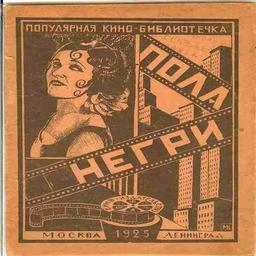

Literal caption:  a book with a woman in the middle and a movie strip
Pragmatic caption:  the book cover for the book of the ussr


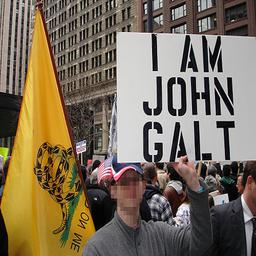

Literal caption:  a group of people holding signs in the street
Pragmatic caption:  the sign says i am john cat


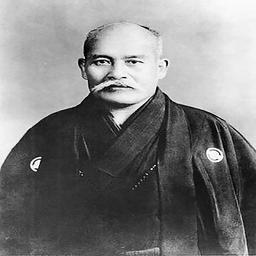

Literal caption:  a man in a kimono robe and a hat
Pragmatic caption:  portrait of a japanese man


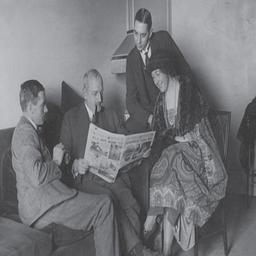

Literal caption:  a group of people sitting in a room
Pragmatic caption:  a group of men and women sit in a room, reading and discussing


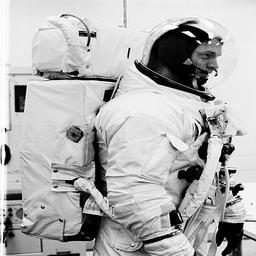

Literal caption:  two men in spacesuits in a room
Pragmatic caption:  two men in spacesuits standing next to each other men


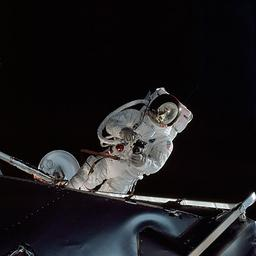

Literal caption:  astronaut in space station
Pragmatic caption:  astronaut and spacecraft docked to the international space station


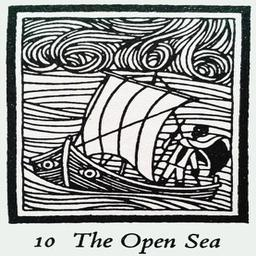

Literal caption:  the cover of the book, the opp sea
Pragmatic caption:  the op sea and other poems


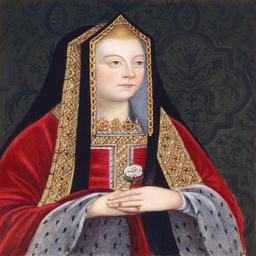

Literal caption:  a painting of a woman in a red dress
Pragmatic caption:  a painting of a lady in a red and gold dress


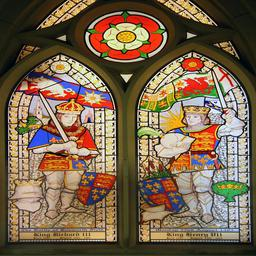

Literal caption:  a stained glass window
Pragmatic caption:  a window with a stained glass and a knight


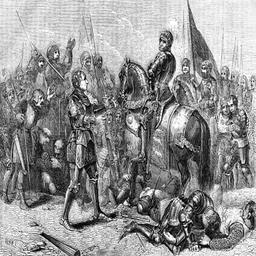

Literal caption:  the battle of the nations
Pragmatic caption:  the battle of antioch, the first crusade of constantinople


In [26]:
# Inspect some results
for img, r in zip(people_images[:10], results[:10]):
    display(img)
    print("Literal caption: ", r[0])
    print("Pragmatic caption: ", r[1])

Now, if we were to do image retrieval with our generated captions, let's take a look at how retrieval performance changes if we retrieve based on the greedy output from the captioner vs. the more discriminative captions selected by RSA.

Your top-1 retrieval accuracy with pragmatic captions should be >70%.

In [27]:
literal_retrieval_outputs = rank_images([r[0] for r in results], people_images)
print("Top-1 accuracy (literal):", top1_accuracy(literal_retrieval_outputs))
pragmatic_retrieval_outputs = rank_images([r[1] for r in results], people_images)
print("Top-1 accuracy (pragmatic):", top1_accuracy(pragmatic_retrieval_outputs))

np.save("image_retrieval_pragmatic.npy", pragmatic_retrieval_outputs)

Top-1 accuracy (literal): 0.55
Top-1 accuracy (pragmatic): 0.81


## Qualitative Analysis Part 3: Captioning

In your report:
* Look at a few examples of captions generated by the literal and the pragmatic captioner. What are some qualitative trends and why would they come out of RSA inference?

# Submission

Your final submission should include the following files:

* hw5.ipynb (this file; please rename to match)
* image_retrieval_caption.npy
* image_retrieval_desc.npy
* pragmatic_preds.npy
* image_retrieval_pragmatic.npy
* report.pdf (containing qualitative analysis for Parts 1-3)